# Object Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.

Note: you may need to restart the kernel to use updated packages.


rm: cannot remove 'nohup.out': No such file or directory
cat: nohup.out: No such file or directory
22/10/29 01:42:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
10-29-2022 01:43:01 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF FastRCNNObjectDetector already exists, nothing added.
10-29-2022 01:43:01 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Array_Count already exists, nothing added.
10-29-2022 01:43:01 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Crop already exists, nothing added.
10-29-2022 01:43:01 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF DummyObjectDetector already exists, nothing added.
10-29-2022 01:43:01 

Note: you may need to restart the kernel to use updated packages.


### Getting the Video Files

In [2]:
# Getting the video files
!wget -nc https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4
# Getting the FastRCNN object detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/fastrcnn_object_detector.py

--2022-10-29 01:43:09--  https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k00wge9exwkfxz6/ua_detrac.mp4 [following]
--2022-10-29 01:43:09--  https://www.dropbox.com/s/raw/k00wge9exwkfxz6/ua_detrac.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc37352255f558b0c3af4d49e683.dl.dropboxusercontent.com/cd/0/inline/BvuDSzkr7SqYjmTRQ1ecs29mUcbjMjBCugnSrlGHGBr2j3jSIbwtD0CkrPI0MQ_TILR6ZXF0pAE0ib4L3fIDhzRSwogz2UwyoTfMZOme0--1mpY4aZFEwTshqa7s05ux4VqFmoAIA58WrG3UxAhrdfaP0Z6o6TYnZk-NPHVNF4Um3w/file# [following]
--2022-10-29 01:43:10--  https://uc37352255f558b0c3af4d49e683.dl.dropboxusercontent.com/cd/0/inline/BvuDSzkr7SqYjmTRQ1ecs29mUcbjMjBCugnSrlGHGBr2j3jSIbwtD0CkrPI0MQ_TILR6ZXF0pAE0i

### Load the surveillance videos for analysis

In [3]:
cursor.execute('DROP TABLE ObjectDetectionVideos')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD FILE "ua_detrac.mp4" INTO ObjectDetectionVideos;')
response = cursor.fetch_all()
print(response)

@status: -1
@batch: None
@error: ObjectDetectionVideos does not exist. Create the table using CREATE TABLE.
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: ua_detra...
@batch_size: 1
@identifier_column: None
@query_time: 0.05457927938550711


10-29-2022 01:43:11 ERROR [binder_utils:binder_utils.py:bind_table_info:0121] ObjectDetectionVideos does not exist. Create the table using CREATE TABLE.
10-29-2022 01:43:11 WARNING[command_handler:command_handler.py:handle_request:0075] ObjectDetectionVideos does not exist. Create the table using CREATE TABLE.


### Visualize Video

In [6]:
from IPython.display import Video
Video("ua_detrac.mp4", embed=True)

### Optional - Register FasterRCNN (object detection) model into EVA 

#### Syntax
  
  `CREATE UDF [ IF NOT EXISTS ] <name> 
      INPUT  ( [ <arg_name> <arg_data_type> ] [ , ... ] )
      OUTPUT ( [ <result_name> <result_data_type> ] [ , ... ] )
      TYPE  <udf_type_name>
      IMPL  '<path_to_implementation>'`

#### Required Parameters
`<name>` - specifies the unique identifier for the UDF.

`[ <arg_name> <arg_data_type> ] [ , ... ]` - specifies the name and data type of the udf input arguments. Name is kept for consistency (ignored by eva right now), arguments data type is required. `ANYDIM` means the shape is inferred at runtime.

`[ <result_name> <result_data_type> ] [ , ... ]` - specifies the name and data type of the udf output arguments. 
Users can access a specific output of the UDF similar to access a column of a table. Eg. `<name>.<result_name>` 

`<udf_type_name>` - specifies the identifier for the type of the UDF. UDFs of the same type are assumed to be interchangeable. They should all have identical input and output arguments. For example, object classification can be one type. 

`<path_to_implementation>` - specifies the path to the implementation class for the UDF

In [14]:
cursor.execute("""CREATE UDF IF NOT EXISTS FastRCNNObjectDetector
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'fastrcnn_object_detector.py';
      """)
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF FastRCNNObjectDetector successfully added ...
@batch_size: 1
@identifier_column: None
@query_time: 0.692649245262146


: 

### Run Object detector on the video

In [8]:
cursor.execute("""SELECT id, FastRCNNObjectDetector(data) 
                  FROM ObjectDetectionVideos 
                  WHERE id < 20""")
response = cursor.fetch_all()
print(response)

/home/jarulraj3/eva/test_evadb/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


@status: 0
@batch: Batch Object:
@dataframe:     objectdetectionvideos.id  \
0                          0   
1                          1   
2                          2   
3                          3   
4                          4   
5                          5   
6                          6   
7                          7   
8                          8   
9                          9   
10                        10   
11                        11   
12                        12   
13                        13   
14                        14   
15                        15   
16                        16   
17                        17   
18                        18   
19                        19   

                        fastrcnnobjectdetector.labels  \
0   [person, car, car, car, car, car, car, car, ca...   
1   [person, car, car, car, car, car, car, car, ca...   
2   [person, car, car, car, car, car, car, car, ca...   
3   [person, car, car, car, car, car, car, car, ca... 

### Visualize output of Object detector on the video

In [10]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['fastrcnnobjectdetector.bboxes', 'fastrcnnobjectdetector.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness) 
                # frame label
                cv2.putText(img, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
            video.write(img)

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(img)
                plt.show()
        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

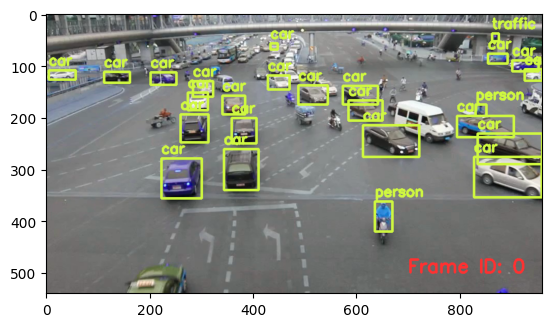

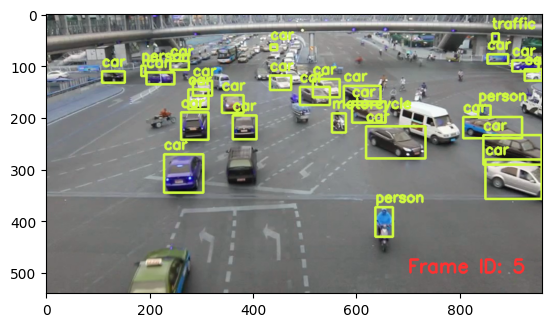

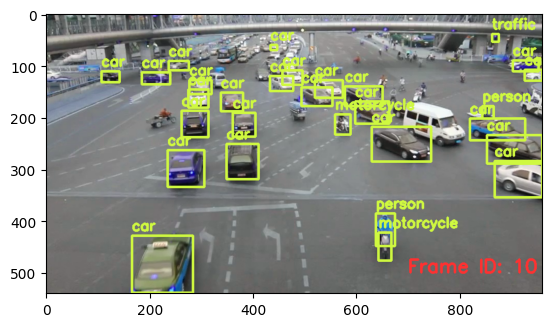

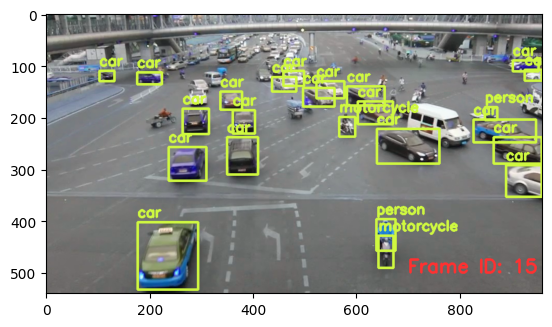

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\n\x85S...')

In [12]:
from ipywidgets import Video, Image
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

dataframe = response.batch.frames
annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)

### Dropping a udf
simply enter command `drop udf udf_name`

In [13]:
cursor.execute("DROP UDF FastRCNNObjectDetector;")
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                  0
0  UDF FastRCNNObjectDetector successfully dropped
@batch_size: 1
@identifier_column: None
@query_time: 0.015240591950714588
